In [1]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [2]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [3]:
SD = 0.05 * (0.8 ** -2) # -4 ... 10 
print('SD:', SD)

SD: 0.078125


In [4]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ACC', 'ADSK', 'AMD', 'AMZN', 'ANET', 
    'APPH', 'ARVL', 'AXON', 'BBY','BROS', 'BYND', 'COIN', 'COUR', 
    'CRWD', 'DDOG', 'DKNG', 'DOCU', 'DUOL', 'EDIT', 'ETSY', 'EVGO', 
    'FTCH', 'FUV', 'FVRR', 'GH', 'GMED', 'GOOG', 'INTG', 'ISRG', 'JD',
    'LSPD', 'LULU','MDB', 'MEDP', 'MELI', 'MNST', 'MSFT', 'MTCH',
    'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW', 'PINS', 'PTON',
    'PUBM', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE', 'SHOP',
    'SOLO', 'SPLK', 'SQ', 'TASK', 'TDOC','TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

81

In [5]:
N_YEARS = 50
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = '1978-07-26' #str(TODAY - timedelta(N_DAYS))
START, TODAY

('1978-07-26', datetime.date(2021, 12, 23))

In [6]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [7]:
batch = SYMBOLS + INDICES # run all
stock_loader = Loader(batch, START, verbose=True)
data = stock_loader.download()

[*********************100%***********************]  84 of 84 completed
Generating derived columns...
   ...AAPL
   ...ABMD
   ...ABNB
   ...ACC
   ...ADSK
   ...ALGN
   ...AMD
   ...AMZN
   ...ANET
   ...APPH
   ...ARVL
   ...AXON
   ...BBY
   ...BROS
   ...BYND
   ...CDNS
   ...COIN
   ...COUR
   ...CRWD
   ...DDOG
   ...DKNG
   ...DOCU
   ...DUOL
   ...EDIT
   ...ETSY
   ...EVGO
   ...FTCH
   ...FUV
   ...FVRR
   ...GH
   ...GMED
   ...GOOG
   ...INTG
   ...ISRG
   ...JD
   ...LSPD
   ...LULU
   ...MDB
   ...MEDP
   ...MELI
   ...MNST
   ...MSFT
   ...MTCH
   ...NVCR
   ...NVDA
   ...NYT
   ...OKTA
   ...OPEN
   ...PANW
   ...PINS
   ...PTON
   ...PUBM
   ...QDEL
   ...RBLX
   ...RDFN
   ...RGEN
   ...ROKU
   ...ROST
   ...SE
   ...SHOP
   ...SOLO
   ...SPGI
   ...SPLK
   ...SQ
   ...TASK
   ...TDOC
   ...TEAM
   ...TREX
   ...TRUP
   ...TSLA
   ...TTD
   ...TTWO
   ...TWLO
   ...TWTR
   ...UPST
   ...VEEV
   ...WDAY
   ...WK
   ...XPEV
   ...ZEN
   ...ZNGA
   ...^GSPC
   ...^IXIC
  

In [8]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [9]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [10]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data. '
              'Initialized as None.')

In [11]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [12]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)

In [13]:
if TODAY.weekday() == 0:
    !say update standard deviation




----------------------------------------------------------------------
                                 AAPL
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 662.7746118349825
Refitting current best...
Current best ma returns: 671.8957014666262
Fraction Invested: 0.9910359161258742
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 671.8412310386793
Invested: 0.9910359161258742
New best: 671.8426412731268
Invested: 0.9910359161258742
New best: 671.842806590669
Invested: 0.9910359161258742
New best: 672.6928531943121
Invested: 0.9910359161258742
New best: 672.6975874811803
Invested: 0.9910359161258742
New best: 672.7733947031172
Invested: 0.9910359161258742
New best: 672.7644644534274
Invested: 0.9910359161258742
New best: 672.8609835843413
Invested: 0.9910359161258742



Beginning ew_ma method...
-------------------------

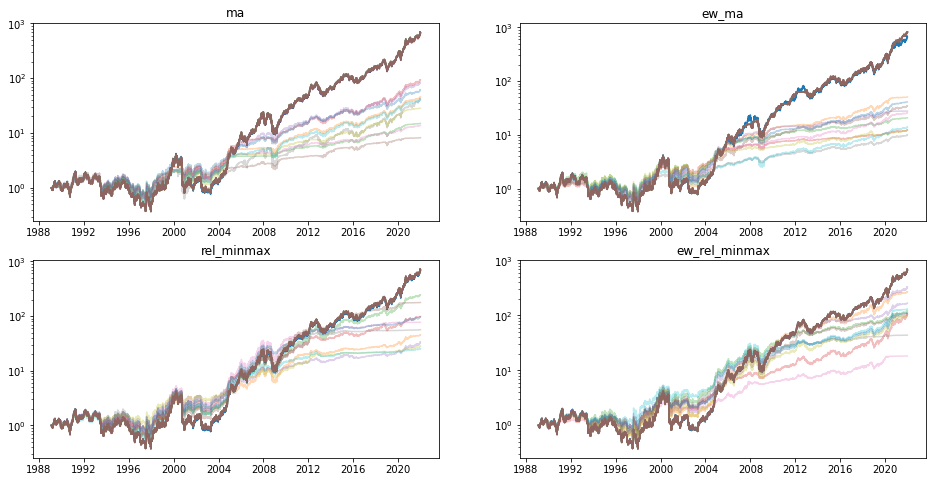

Saving AAPL params...



----------------------------------------------------------------------
                                 ABMD
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 91.64138267780173
Refitting current best...
Fraction Invested: 1
Beginning random search...
New best: 94.09319304733427
Invested: 0.7645915204408088
Round: 10
Beginning adjusted search...
New best: 94.21950856095711
Invested: 0.7645915204408088
New best: 94.78616514923337
Invested: 0.7645915204408088
New best: 96.641556659759
Invested: 0.7645915204408088
New best: 97.7587673303503
Invested: 0.7645915204408088
New best: 105.18265556168063
Invested: 0.7645915204408088
New best: 105.29921788692346
Invested: 0.7645915204408088
New best: 106.22922625271335
Invested: 0.7645915204408088
New best: 107.4317634455361
Invested: 0.7645915204408088
Round: 15


Beginning ew_ma method

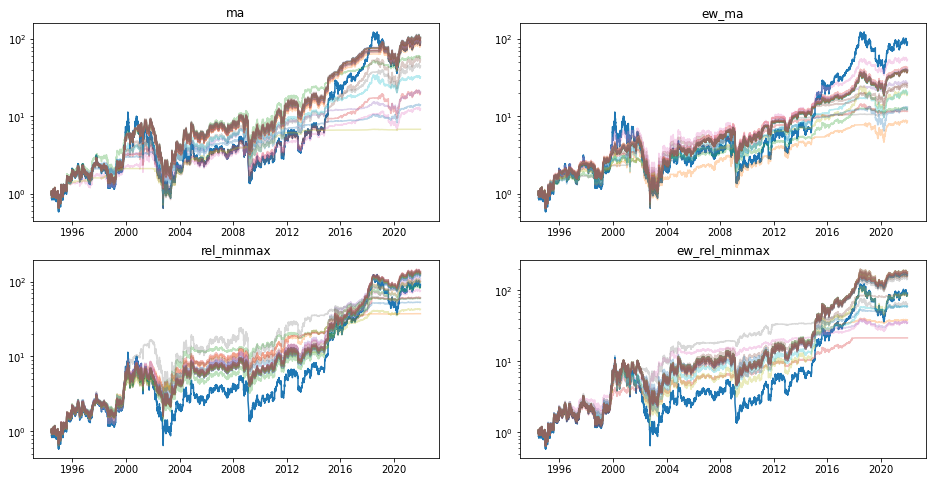

Saving ABMD params...



----------------------------------------------------------------------
                                 ABNB
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 0.8028107524213298
Refitting current best...
Current best ma returns: 1.0001804366013851
Fraction Invested: 0.7883395413759134
Beginning random search...
New best: 1.0129849918128981
Invested: 0.6525190912956425
New best: 1.0147608393833059
Invested: 0.81084306331563
New best: 1.0303206208121511
Invested: 0.5813029420965543
Round: 10
Beginning adjusted search...
New best: 1.0324082421663987
Invested: 0.6689400582834152
New best: 1.035588182291555
Invested: 0.6689400582834152
New best: 1.04422333336391
Invested: 0.6689400582834152
New best: 1.0528582871623748
Invested: 0.6689400582834152
New best: 1.0538196361406775
Invested: 0.6689400582834152
New best: 14 1.06201106879

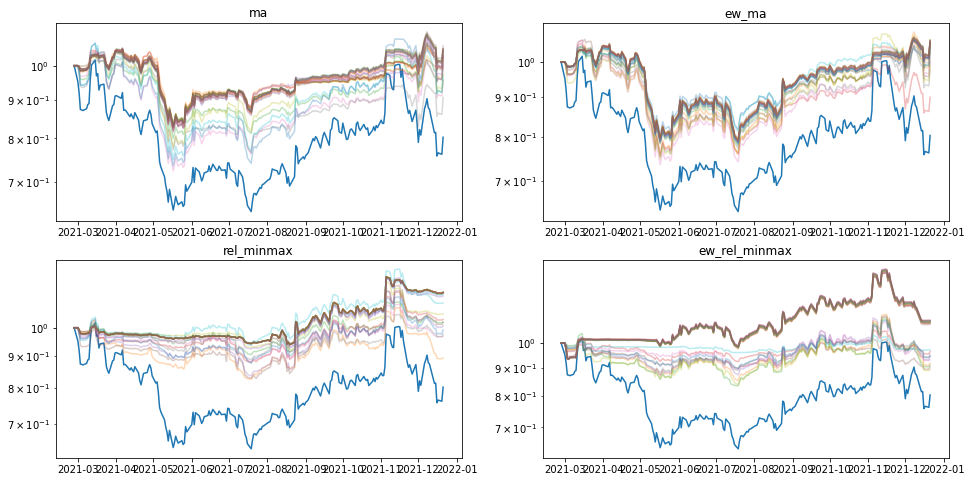

Saving ABNB params...



----------------------------------------------------------------------
                                 ACC
----------------------------------------------------------------------
No saved data. Initialized as None


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.4149755132525166
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.4149755132525166
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 3.4149755132525166
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_rel_minmax method...


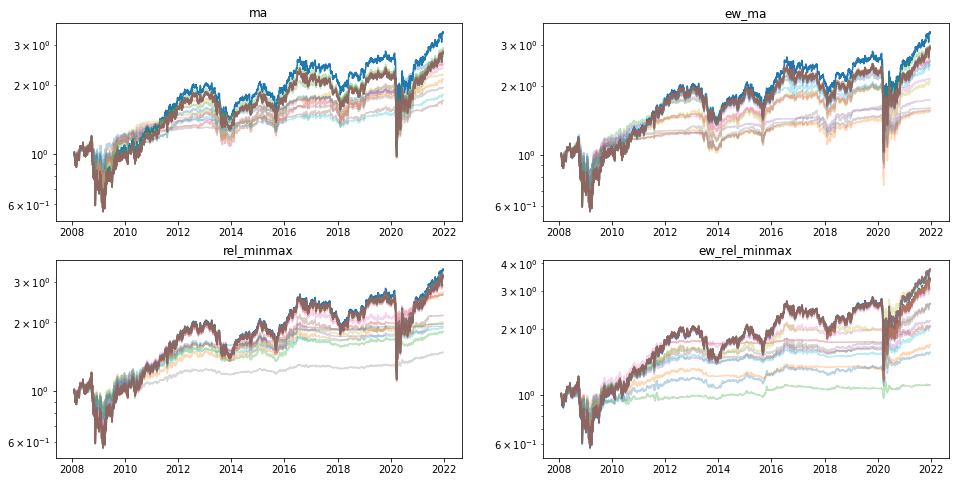

Saving ACC params...



----------------------------------------------------------------------
                                 ADSK
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 52.499228647516155
Refitting current best...
Current best ma returns: 52.55289969182966
Fraction Invested: 0.9938429044033603
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 52.535424660083464
Invested: 0.9938429044033603
New best: 52.54548608029696
Invested: 0.9938429044033603
New best: 52.63603759028748
Invested: 0.9938429044033603
New best: 52.720410455439435
Invested: 0.9938429044033603
New best: 52.744655665728594
Invested: 0.9938429044033603
New best: 52.74480501527496
Invested: 0.9938429044033603
New best: 52.74703311428489
Invested: 0.9938429044033603
New best: 52.75329271087497
Invested: 0.9938429044033603
New best: 52.75544804760893


In [ ]:
N_RAND = 10
N_ADJ = 15

for stock in batch:
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(stock_data, 
                      N_CUTS, 
                      best_param_set=best_params, 
                      best_returns=best_returns, 
                      sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [ ]:
def get_summary(stocks):
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {100 * best_pct:.2f}% in')
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue

In [ ]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
get_summary(batch)

In [ ]:
!say qp is dunzo

IXIC: Nasdaq